In [1]:
## Load packages: 
!pip3 install geopy
import requests
import json, random, time, tqdm, warnings
import numpy as np
import pandas as pd
import geopy.geocoders  # GeoPy - see https://pypi.org/project/geopy/
from geopy.geocoders import Nominatim # retrieve coordinates from addresses etc.
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

# 1. Setting up the data

## 1.1 Scraping function for Bolighed.dk
This is a function to scrape data on supply prices for real estate apartments from Bolighed.dk.

In [2]:
# First we test if we can get some data from Bolighed 
url = 'https://bolighed.dk/api/external/market/propertyforsale/?limit=40&offset=0&view=list&type__in=300&ordering=mtid'
response = requests.get(url)

if response.ok:  # response.ok is True if status code is 200
    r = response.json()
else:
    print('error')
    
listings = r['count'] # = 7855 opslag

# Collect all links from search on Bolighed by changing the page-parameter
links = []

for offset in range(0,listings+40,40):
    url = 'https://bolighed.dk/api/external/market/propertyforsale/?limit=40&offset={o}&view=list&type__in=300&ordering=mtid'.format(o = offset)
    links.append(url)
    
# This code is for scraping all pages off the search criteria for owner appartments. NB!! Only run this once. 
done = set()
data = []

for url in tqdm.tqdm(links):
    response = requests.get(url)
    
    if response.ok:
        r = response.json()
    else:
        print('error')

    data += r['results']
    time.sleep(5.0)

100%|██████████| 200/200 [19:08<00:00,  5.74s/it]


## 1.2 Function to structure raw data output

In [24]:
def datastructuring(data, timeout):
    geopy.geocoders.options.default_user_agent = 'my_app/1'
    geopy.geocoders.options.default_timeout = timeout
    raw_data=pd.DataFrame(data)
    # Keep the columns we want to keep and name them
    sorted_data = raw_data.iloc[:,[0,2,3,4,7,8,12,14,15,16,18,21]]
    sorted_data.columns = ['Address', 'Rooms', 'Area','Land_area','Owner_expense',
                           'Energy_mark', 'Price','Days_on_market',
                           'Zip_code', 'Town', 'Price_development', 'Sqm_price']
    # Unpack all latitudes and longitudes and add to dataframe
    #Unpack all latitudes and longitudes and add to dataframe
    latitude = []
    for i in range(len(raw_data)):
        if raw_data['geometry'][i]!=None:
            row_i = raw_data['geometry'][i]['coordinates'][0]
            latitude.append(row_i)
        else:
            row_i=None
            latitude.append(row_i)
    longitude = []
    for i in range(len(raw_data)):
        if raw_data['geometry'][i]!=None:
            row_i = raw_data['geometry'][i]['coordinates'][1]
            longitude.append(row_i)
        else:
            row_i=None
            longitude.append(row_i)
    # Add latitude and longitude to sorted dataframe.
    sorted_data.insert(loc=0, column='Latitude', value=latitude)
    sorted_data.insert(loc=0, column='Longitude', value=longitude)
    
    # Convert zip_code from str to int
    sorted_data['Zip_code'] = sorted_data['Zip_code'].astype(int, inplace=True)
    # Sort only zipcodes from Copenhagen
    cph = sorted_data[(sorted_data.Zip_code < 3000)].copy()
    cph.reset_index(inplace=True, drop=True)
    # Make a column of indexes for energy mark
    energysaving = []
    for i, row in cph['Energy_mark'].iteritems():
        if row == 'G':
            energysaving.append(0)
        elif row == 'F':
            energysaving.append(1)
        elif row == 'E':
            energysaving.append(2)
        elif row == 'D':
            energysaving.append(3)
        elif row == 'C':
            energysaving.append(4)
        elif row == 'B':
            energysaving.append(5)
        elif row == 'A':
            energysaving.append(6)
        elif row == 'A10':
            energysaving.append(7)
        elif row == 'A15':
            energysaving.append(8)
        elif row == 'A20':
            energysaving.append(9)
        else:
            energysaving.append(None)
    cph.insert(loc=0, column='Energy_saving', value=energysaving)
    # Set all missing values with energy_saving to mean.
    cph.Energy_saving.fillna(5.0, inplace=True)
    
    # Create 'floor' variable
    floor = []
    for i, row in cph['Address'].iteritems():
        if ',' in row:
            sec_part = row.split(', ', 1)[1] # split once, keep 2nd part
            if sec_part[:2].isdigit():  # 399 with two or more digits (unindentified floor, 362 >= '20')
                floor_int = int(sec_part[0])  # assume 1st digit indicates floor
                floor.append(floor_int)
            elif sec_part[0].isdigit():
                floor_int = int(sec_part[0])
                floor.append(floor_int)
            else:
                floor.append(int(0))
        else:
            floor.append(int(0))
    cph.insert(loc=0, column='Floor', value=floor)

############################################################################
#             Code missing latitudes and longitudes using GeoPy            #
############################################################################
    address_simple = []
    for i, row in cph['Address'].iteritems():
        if 'George Marshalls Vej' in row:
            address_simple.append('Fiskerihavnsgade 8')
        elif 'Amerika Plads' in row:
            address_simple.append(row.replace('Plads', 'Pl.'))
        elif 'HUSBÅD' in row:
            address_simple.append(row.split(' - HUSBÅD', 1)[0])  # Keep first part
        else:
            address_simple.append(row.split(',', 1)[0]) # split once, keep 1st part
    cph.insert(loc=0, column='Address_simple', value=address_simple)

    town_simple = []
    for i, row in cph['Town'].iteritems():
        if 'København' in row:
            town_simple.append('København')  # Keep 'København' only
        elif 'Nordhavn' in row:
            town_simple.append('København')  # Keep 'København' only
        else:
            town_simple.append(row)
    cph.insert(loc=0, column='Town_simple', value=town_simple)

    cph['Full_address'] = cph['Address_simple'].map(str) + ', ' + cph['Zip_code'].map(str) + ' ' + cph['Town_simple']

    # Thoose with missing latitude and longitude from scrape
    cph['Missing'] = cph['Longitude'].isnull()
    cph['Full_add'] = cph['Full_address']*cph['Missing']

    # Retrieve coordinates from column of addresses
    geolocator = Nominatim()
    # geolocator.headers  # check header
    # geolocator.timeout  # check time_out
    lati = []
    longi = []

    for row in tqdm.tqdm(cph['Full_add']):
        row_string = str(row)
        if len(row_string) > 0:
            location = geolocator.geocode(row_string)
            if isinstance(location, geopy.location.Location):
                lati.append(float(location.latitude))
                longi.append(float(location.longitude))
            else:
                print('Not found: ',row_string)
                lati.append(None)
                longi.append(None)
        else:
            lati.append(None)
            longi.append(None)
    cph.insert(loc=0, column='Lati', value=lati)
    cph.insert(loc=0, column='Longi', value=longi)
    cph['Latitude'] = cph['Latitude'].fillna(cph['Lati'])
    cph['Longitude'] = cph['Longitude'].fillna(cph['Longi'])
    
    # Sort columns in order which makes sence
    cph = cph.drop(['Longi', 'Lati', 'Town', 'Town_simple', 'Address_simple',
        'Full_address', 'Missing', 'Full_add'], axis=1)
    cph = cph.reindex(columns=['Address','Zip_code' ,'Latitude', 'Longitude' ,
        'Floor', 'Rooms', 'Area', 'Land_area','Sqm_price','Price','Owner_expense',
        'Price_development', 'Days_on_market','Energy_saving'])
    # Create log variable of square meter price 
    cph.insert(loc=8, column='log_sqm_price', value=np.log(cph.Sqm_price))
    print(cph.isnull().sum())
    return cph


In [25]:
# Create data set from structuring function: 
CPH = datastructuring(data, 15)
raw_data=pd.DataFrame(data)
print('First we had a raw data set with ' + str(len(raw_data)) + ' observations.') #7933 observations
print('Now we have a sorted data set with ' + str(len(CPH)) + ' observations.')    #3924 observations

/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 3924/3924 [00:12<00:00, 304.19it/s]

Address              0
Zip_code             0
Latitude             0
Longitude            0
Floor                0
Rooms                0
Area                 0
Land_area            0
log_sqm_price        0
Sqm_price            0
Price                0
Owner_expense        0
Price_development    0
Days_on_market       0
Energy_saving        0
dtype: int64
First we had a raw data set with 7933 observations.
Now we have a sorted data set with 3924 observations.


In [26]:
#Get an overview of types and dataframe:
print(CPH.dtypes)
CPH.head()

Address               object
Zip_code               int64
Latitude             float64
Longitude            float64
Floor                  int64
Rooms                  int64
Area                   int64
Land_area              int64
log_sqm_price        float64
Sqm_price              int64
Price                  int64
Owner_expense          int64
Price_development    float64
Days_on_market         int64
Energy_saving        float64
dtype: object


,Address,Zip_code,Latitude,Longitude,Floor,Rooms,Area,Land_area,log_sqm_price,Sqm_price,Price,Owner_expense,Price_development,Days_on_market,Energy_saving
0,"Islands Brygge 65, 1 TV",2300,55.662144,12.571804,1,3,97,0,10.819778,50000,4850000,4025,0.0,1,4.0
1,"Islands Brygge 38E, 4 TV",2300,12.566754,55.658113,4,3,101,0,10.957381,57376,5795000,4297,0.0,1,8.0
2,"Blegdamsvej 8, 5",2200,12.562238,55.691351,5,3,72,0,10.898534,54097,3895000,2739,0.0,1,3.0
3,"Roskildevej 189A, st tv",2500,12.484196,55.672463,0,2,64,0,10.215081,27312,1748000,2072,0.0,1,4.0
4,"Monica Zetterlunds Vej 5, th",2450,12.548417,55.646182,0,3,107,0,10.711079,44850,4799000,4148,0.0,1,5.0


## 1.3 Append municipality onto dataset 

In [27]:
# Get data from Statistics Denmark with zip_code: 
# Get zip codes and municipalities
url_post = 'https://www.dst.dk/ext/4393839853/0/kundecenter/Tabel-Postnumre-kommuner-og-regioner--xlsx'
df_muni = pd.read_excel(url_post)
df2_muni = df_muni[4:]
df2_muni.rename(columns={'Postnumre, kommuner og regioner, 1.1.2016':'Zip','Unnamed: 1':'Municipality','Unnamed: 2':'Region'}, inplace=True)

# Split data: we want to seperate zip code and village as well as municipality number and municipality
zip_split = pd.DataFrame(df2_muni.Zip.str.split(' ',1).tolist(),
                                   columns = ['Zip','Village'])

mun_split = pd.DataFrame(df2_muni.Municipality.str.split(' ',1).tolist(),
                                   columns = ['Mun. no.','Municipality'])

merge = pd.concat([zip_split, mun_split], axis=1, sort=False)


#Construct new variable that only contain municpalities with zip code below 3000
mun_zip = merge[['Zip','Municipality']] 
mun_zip['Int zip'] = mun_zip['Zip'].astype(int)
our_sample = mun_zip[(mun_zip['Int zip'] < 3000)]
# Drop string zip_code column: 
our_sample.drop('Zip', axis=1 ,inplace=True)
# Give common name to this datasets zip code and our: 
our_sample.rename(columns={'Int zip': 'Zip_code'}, inplace=True)
# Keep last duplicate of kommunes
our_sample.drop_duplicates(keep='last', subset='Zip_code', inplace=True)
# Now merge datasets on zip code: 
CPH_merged= pd.merge(CPH, our_sample, on='Zip_code', how='left')
CPH_kom =CPH_merged.reindex(columns=['Address','Zip_code', 'Municipality', 'Latitude', 'Longitude' ,'Rooms', 
                                        'Area', 'Land_area','log_sqm_price','Sqm_price','Price','Owner_expense', 'Price_development',
                                        'Energy_mark','Energy_saving', 'Days_on_market'])
CPH_kom.head()

/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

,Address,Zip_code,Municipality,Latitude,Longitude,Rooms,Area,Land_area,log_sqm_price,Sqm_price,Price,Owner_expense,Price_development,Energy_mark,Energy_saving,Days_on_market
0,"Islands Brygge 65, 1 TV",2300,Tårnby,55.662144,12.571804,3,97,0,10.819778,50000,4850000,4025,0.0,NaN,4.0,1
1,"Islands Brygge 38E, 4 TV",2300,Tårnby,12.566754,55.658113,3,101,0,10.957381,57376,5795000,4297,0.0,NaN,8.0,1
2,"Blegdamsvej 8, 5",2200,Frederiksberg,12.562238,55.691351,3,72,0,10.898534,54097,3895000,2739,0.0,NaN,3.0,1
3,"Roskildevej 189A, st tv",2500,København,12.484196,55.672463,2,64,0,10.215081,27312,1748000,2072,0.0,NaN,4.0,1
4,"Monica Zetterlunds Vej 5, th",2450,København,12.548417,55.646182,3,107,0,10.711079,44850,4799000,4148,0.0,NaN,5.0,1


# 2 Descriptive statistics

## 2.1 Make table of descriptive statistics

In [30]:
# Take subset of table for descriptive statistics. 
vars_ = ['log_sqm_price', 'Sqm_price', 'Price' ,'Rooms', 'Area','Energy_saving', 'Days_on_market']
data_0 = CPH.loc[:,vars_]
data_1 = data_0.describe()
# Round of decimal points and choose descriptives of interest. 
CPH_desc = data_1.round(decimals=1)
CPH_desc = CPH_desc.iloc[[1,2,3,5,7],:]
descritives = CPH_desc.transpose()
descritives
# Få tabel i LaTeX format: 
#descritives.to_latex() #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_latex.html

,mean,std,min,50%,max
log_sqm_price,10.6,0.3,9.3,10.7,11.6
Sqm_price,43426.2,12113.2,10910.0,43061.0,111071.0
Price,4158047.7,2575389.4,550000.0,3495000.0,25000000.0
Rooms,3.1,1.2,0.0,3.0,16.0
Area,92.6,40.4,24.0,86.0,616.0
Energy_saving,4.0,1.9,0.0,4.0,9.0
Days_on_market,100.7,122.1,1.0,70.0,3539.0


## 2.2 Choropleth maps
This a link for CHOROPLETH GUIDE
https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

And this is a link for colormaps: 
https://matplotlib.org/users/colormaps.html

In [31]:
# number of appartments for sale by municipality: 
CPH_kom.groupby(['Municipality']).size().reset_index(name='counts')

,Municipality,counts
0,Albertslund,70
1,Ballerup,15
2,Brøndby,3
3,Egedal,18
4,Fredensborg,2
5,Frederiksberg,678
6,Furesø,34
7,Gentofte,219
8,Gladsaxe,102
9,Greve,7


In [32]:
# Get the shape:  
Region_0 = gpd.read_file("/Users/sarahkoelemij/Downloads/ADM/KOMMUNE.shp")

# Format the shape dataframe to only contain relevant stuff: 
Region_1 = Region_0[['KOMNAVN', 'REGIONNAVN','geometry']]
Region_2 = Region_1[(Region_1.REGIONNAVN == 'Region Hovedstaden')].copy()
shape = Region_2.rename(columns={'KOMNAVN':'Municipality'})

# Drop Bornholm and Christiansø from map
shape.drop(shape[shape.Municipality =='Bornholm'].index, inplace=True)
shape.drop(shape[shape.Municipality =='Christiansø'].index, inplace=True)

# Choose the subsample of the dataframe you want to plot on the Choropleth:  
data = pd.read_csv('27-08-18_med kommuner.csv')
map_data = data[['Municipality','Sqm_price', 'log_sqm_price', 'Owner_expense']]

# Remove municipalities without listings from map
shape_1 = shape[(shape.Municipality != 'Frederikssund')].copy()
shape_2 = shape_1[(shape.Municipality != 'Helsingør')].copy()
shape_3 = shape_2[(shape.Municipality != 'Gribskov')].copy()
shape_4 = shape_3[(shape.Municipality != 'Halsnæs')].copy()
shape_5 = shape_4[(shape.Municipality != 'Hillerød')].copy()

# join the geodataframe with the cleaned up csv dataframe
merged = shape_5.set_index('Municipality').join(map_data.set_index('Municipality'))
# Get descriptive statistics to look at borders for the map index
merged.describe()


/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/geopandas/geodataframe.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


,Sqm_price,log_sqm_price,Owner_expense
count,166577.000000,166577.000000,166577.000000
mean,44381.919749,10.677573,3743.007228
std,9881.535582,0.212552,1403.455226
min,10910.000000,9.297435,782.000000
25%,37622.000000,10.535344,2725.000000
50%,43208.000000,10.673781,3563.000000
75%,48980.000000,10.799167,4526.000000
max,111071.000000,11.617925,19756.000000


/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


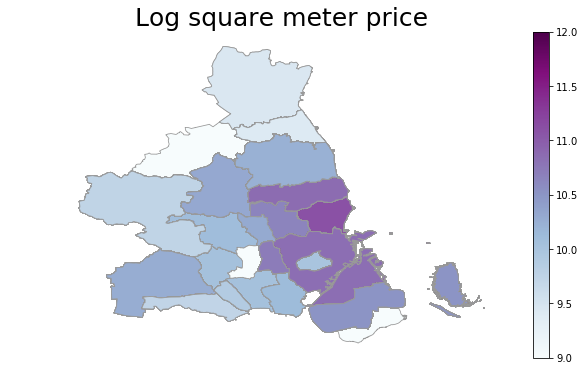

In [33]:
# CHOROPLETH WITH LOG-SQUARE-METER-PRICE ** Get other codes from notebook: 25.08.18
# set a variable that will call whatever column we want to visualise on the map
variable = 'log_sqm_price'

# set the range for the choropleth
vmin, vmax = 9, 12

# create figure and axes for Matplotlib
fig1, ax1 = plt.subplots(1, figsize=(10, 6))

# create map
merged.plot(column=variable, cmap='BuPu', linewidth=0.8, ax=ax1, edgecolor='0.6')
ax1.axis('off')

# add a title
ax1.set_title('Log square meter price', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig1.colorbar(sm)

#Save figure
fig1.savefig('Log_sqm_1.png', dpi=300)

In [34]:
# Create data for listings CHOROPLETH
Listings = data.groupby(['Municipality']).size().reset_index(name='counts')
merged_listings = shape_5.set_index('Municipality').join(Listings.set_index('Municipality'))

/Users/sarahkoelemij/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


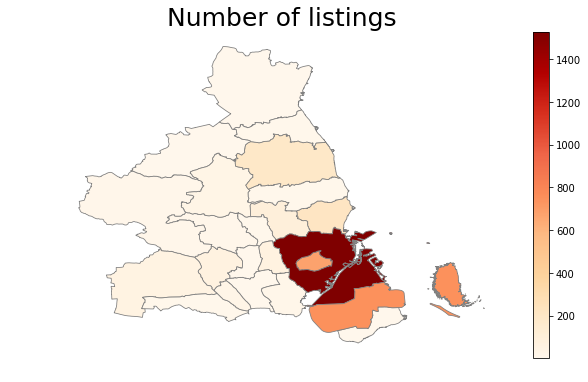

In [35]:
# CHOROPLETH WITH NUMBER OF LISTINGS

# set a variable that will call whatever column we want to visualise on the map
variable = 'counts'

# set the range for the choropleth
vmin, vmax = 3, 1529

# create figure and axes for Matplotlib
fig3, ax3 = plt.subplots(1, figsize=(10, 6))

# create map
merged_listings.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax3, edgecolor='0.5')
ax3.axis('off')

# add a title
ax3.set_title('Number of listings', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig3.colorbar(sm)

fig3.savefig('Listings_1.png', dpi=300)

## 2.3 Descriptive plots

##  2.3.1 Pairplot in order to discover correlations

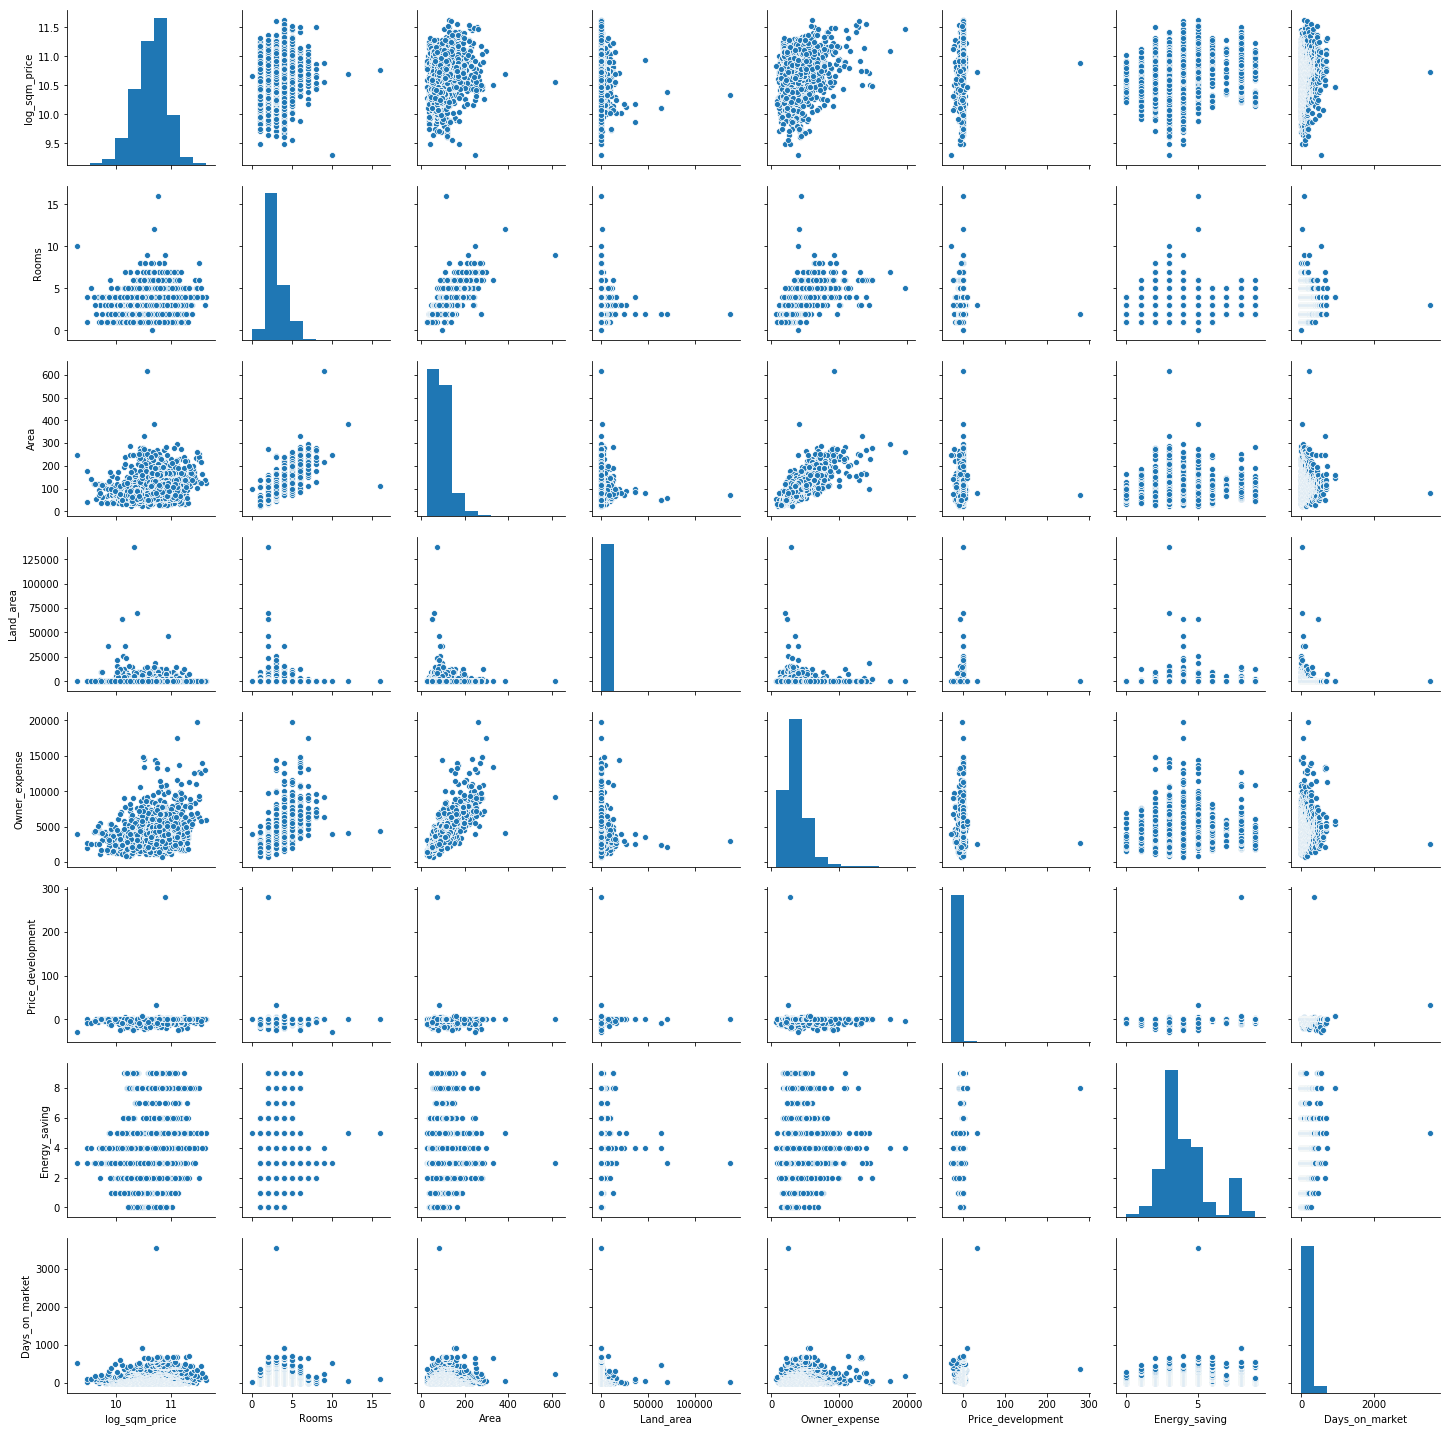

In [37]:
sub_sample = CPH.loc[:,['log_sqm_price', 'Rooms', 'Area', 'Land_area', 'Owner_expense', 'Price_development', 'Energy_saving', 'Days_on_market']]
sub_sample.dropna(inplace=True)
sns.pairplot(sub_sample, palette='pastel')

## 2.3.2 Graph of price and area

[Text(0,0.5,'Price per square meter'),
 Text(0.5,0,'Area'),
 Text(0.5,1,'Log sqm price plottet against area with rooms as hue')]

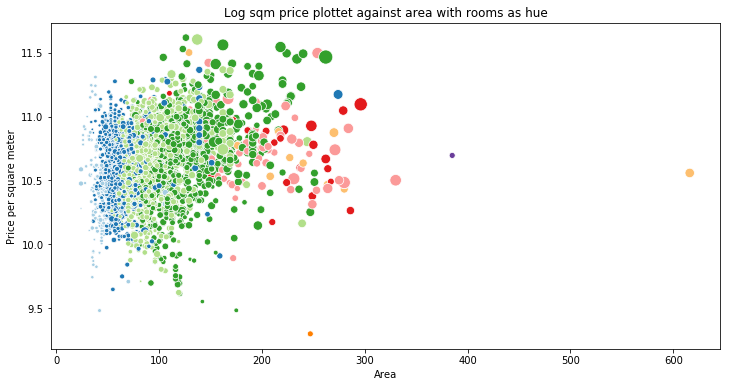

In [38]:
fig3, ax3=plt.subplots(1,1, figsize = (12,6))
ax3 = sns.scatterplot(x='Area', y='log_sqm_price', data=CPH, size = 'Owner_expense', sizes=(2,200), hue='Rooms', palette="Paired", legend=False)
ax3.set(ylabel='Price per square meter', xlabel='Area', title='Log sqm price plottet against area with rooms as hue')

## 2.3.3 Histogram of sqm price distribution

[Text(0,0.5,'Percent'),
 Text(0.5,0,'Price per square meter'),
 Text(0.5,1,'Histogram of square meter prices')]

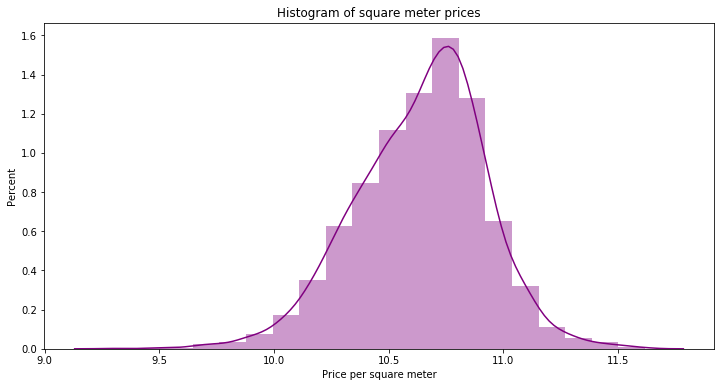

In [39]:
fig2, ax2=plt.subplots(1,1, figsize = (12,6))
ax2 = sns.distplot(CPH['log_sqm_price'], bins=20, kde=True, color='purple')
ax2.set(ylabel='Percent', xlabel='Price per square meter', title='Histogram of square meter prices')